In [1]:
%load_ext autoreload
%autoreload 2

TODO : 

- Corriger bug qui fait que c'est StarSat dans tout le stream et pas seulement dans le sous-stream (uniquement pour BHA-core, graphes ?)
- Retirer les valeurs en dur pour b,e et le langage
- Lancer :D
- Installer jupyter lab sur tiphaineviard.com ?
- Avoir un moyen de dessiner les interieurs etc. ?

# GoodReads Poetry dataset

The full dataset (including other genres) is available at: https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home. We focus here on the _Poetry_ dataset for tractability, as it is the one with the least number of books and reviews.

The files in the `./data/goodreads/` directory are:

- `goodreads_books_poetry.json` : contains information about the books (i.e. nodes)
- `reviews.json` : contains reviews of books by users, with the associated timestamp and ratings

Note that the number of reviews is significantly lower than the number of interactions; indeed, "interacting" on goodreads can be "shelving", posting a review, a rating, etc.

In [2]:
import ujson as json
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from lib.Stream import Stream, StreamStarSat
from datetime import datetime
from lib.Utils import Utils

# nltk.download("punkt")

DELTA = 3600

We isolate relevant words by TF-IDF (Term Frequency - Inverse Document Frequency) score. For a term i in a document d within corpus D, the the TF-IDF is:
$$
    TFIDF_D(i,d) = tf_{i,d} \cdot \log\left(\frac{|D|}{|\{d \in D : i\in d\}|}\right)
$$

In [3]:
def tf_idf(term, document, corpus):
    # TF
    count = 0
    for i in document:
        if i == term:
            count += 1
    frequency = count / len(document)
    # IDF
    df = 0
    for d in corpus:
        if term in set(d):
            df += 1
    return frequency * math.log10(len(corpus) / df)

## Prepare books information

In [4]:
books_file = open("data/goodreads/goodreads_books_poetry.json")
books = {}
has_reviews = 0

for (i, line) in enumerate(books_file):
    data = json.loads(line)
    books[data["book_id"]] = data["description"].split(" ")[0:5]
books["16037549"]

['Number', '30', 'in', 'a', 'series']

## Prepare reviews information

In [5]:
reviews_file = open("data/goodreads/goodreads_reviews_poetry.json")
reviews = []
users_ids = set()
books_ids = set()
labels_users = []
labels_books = []
ratings = {} # sparse matrix ?
links = []
min_date_added = None

for (i,line) in enumerate(reviews_file):
    data = json.loads(line)
    
    # Transform date to timestamp
    date_added = datetime.strptime(data["date_added"], "%a %b %d %H:%M:%S %z %Y")
    date_added = date_added.timestamp()
    
    if min_date_added is None or date_added < min_date_added:
        min_date_added = date_added
    
    users_ids.add(data["user_id"])
    books_ids.add(data["book_id"])
    reviews.append(data["review_text"])
    
    u = data["user_id"]
    v = data["book_id"]

    b = date_added - DELTA
    e = date_added + DELTA
    
    # Pick first 5 words of review and description for each node -- FOR TESTS ONLY --
    label_u = set(data["review_text"].split(" ")[0:5])
    label_v = set(books[v])
    labels_users.extend(label_u)
    labels_books.extend(label_v)
    
    link = {"b": b, "e": e, "u": u, "v": v, "label_u": label_u, "label_v": label_v }
    links.append(link)

for i in range(0, len(links)):
    links[i]["b"] -= min_date_added
    links[i]["e"] -= min_date_added
    

In [6]:
links[0], len(set(labels_users)), len(set(labels_books))

({'b': 189158344.0,
  'e': 189165544.0,
  'u': '3ca7375dba942a760e53b726c472a7dd',
  'v': '402128',
  'label_u': {'I', 'have', 'siblings', 'three', 'younger'},
  'label_v': {"Eliot's", 'S.', 'T.', 'cat', 'playful'}},
 98240,
 35178)

In [68]:
# s = Stream(lang=set(labels_users + labels_books), _fp=open("results.txt", "w+"))
s = Stream(lang=set(labels_users + labels_books))
core_property = StreamStarSat(s, threshold=1)
s.setCoreProperty(core_property)
s.add_links(links[1:3])

In [74]:
s.E

[{'b': 247167760.0,
  'e': 247174960.0,
  'u': '0ef32090550901ead25cb0ea21c4d36b',
  'v': '92270',
  'label_u': {'This', 'collection', 'favorite', 'is', 'my'},
  'label_v': {'Carroll,', 'a', 'and', 'diarist', 'rock'}},
 {'b': 58539490.0,
  'e': 58546690.0,
  'u': '0ef32090550901ead25cb0ea21c4d36b',
  'v': '908708',
  'label_u': {"He's", 'So', 'disturbing.', 'so', 'very,'},
  'label_v': {'bash--a', 'collection', 'of', 'stunning', 'three'}}]

In [69]:
I = set()
for l in s.E:
    I = I.union(l["label_u"])
    I = I.union(l["label_v"])
s.I = I

In [70]:
len(s.I)

19

In [71]:
import time
start = time.perf_counter()
X1 = [(x["u"], (x["b"], x["e"])) for x in s.E ]
X2 = [(x["v"], (x["b"], x["e"])) for x in s.E ]
print("Done X1,X2")
res_int = s.interior(X1, X2)
end = time.perf_counter()
print(end - start)

Done X1,X2
0.0034042069455608726


4 4


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


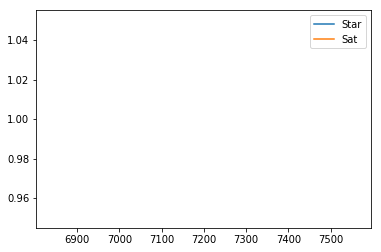

In [72]:
print(len(res_int[0]), len(res_int[1]))
c = Utils.ccdf([ i.e - i.b for i in res_int[0].values() ])
c_2 = Utils.ccdf([ i.e - i.b for i in res_int[1].values() ])

plt.plot(c[0], c[1], label="Star")
plt.plot(c_2[0], c_2[1], label="Sat")
plt.legend()

In [73]:
start = time.perf_counter()
# r = s.bipatterns(s.V, s.V)
r = s.bipatterns(X1, X2)
end = time.perf_counter()
print(end - start)

 set() ({908708 [58539490.0, 58546690.0], 0ef32090550901ead25cb0ea21c4d36b [58539490.0, 58546690.0], 0ef32090550901ead25cb0ea21c4d36b [247167760.0, 247174960.0], 92270 [247167760.0, 247174960.0]}, {908708 [58539490.0, 58546690.0], 0ef32090550901ead25cb0ea21c4d36b [58539490.0, 58546690.0], 0ef32090550901ead25cb0ea21c4d36b [247167760.0, 247174960.0], 92270 [247167760.0, 247174960.0]})
0 Calling enum with set() (set())
     set() ({0ef32090550901ead25cb0ea21c4d36b [58539490.0, 58546690.0], 0ef32090550901ead25cb0ea21c4d36b [247167760.0, 247174960.0]}, {0ef32090550901ead25cb0ea21c4d36b [58539490.0, 58546690.0], 0ef32090550901ead25cb0ea21c4d36b [247167760.0, 247174960.0]})
1 Calling enum with set() (set())
         set() ({0ef32090550901ead25cb0ea21c4d36b [58539490.0, 58546690.0], 0ef32090550901ead25cb0ea21c4d36b [247167760.0, 247174960.0]}, {0ef32090550901ead25cb0ea21c4d36b [58539490.0, 58546690.0], 0ef32090550901ead25cb0ea21c4d36b [247167760.0, 247174960.0]})
2 Calling enum with set() (set

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



RecursionError: maximum recursion depth exceeded while getting the str of an object

In [19]:
s.fp_close()

In [ ]:
print(s.label(("fe488adb521619bebb35028a61c5cdde", 2, 4)))

In [37]:
list(s.V)[0:10]

['fe488adb521619bebb35028a61c5cdde',
 'b41fd369eec21e02a9ad56c8608c3823',
 'edb780cdc27b4fe316fbc72c1588ed09',
 '5153111a7b8025c21253deb34c995e02',
 'c12609bcc482938019be17a15ee4d171',
 '5290036',
 'bbb6abbad493a606c959f445f2cc793f',
 '38b42c397fd456385bc79356a0feacee',
 '848098',
 '5956803']

In [10]:
vectorizer = TfidfVectorizer(use_idf=True)
res = vectorizer.fit_transform(reviews)

Total number of concepts (i.e. distinct words in reviews)

In [11]:
n_users, n_books, n_reviews, n_concepts = len(users), len(books), len(reviews), len(vectorizer.get_feature_names())
print(f"{n_users} users, {n_books} books, {n_reviews} reviews, {n_concepts} concepts (i.e. distinct words in reviews)")

47400 users, 36412 books, 154555 reviews, 403416 concepts (i.e. distinct words in reviews)


In [12]:
tfidf_values = [round(i, 3) for i in res.data]
len(tfidf_values)

9292775

In [13]:
ccdf_values = Utils.ccdf(tfidf_values)
import numpy as np
np.mean(tfidf_values)

0.09749984294250118

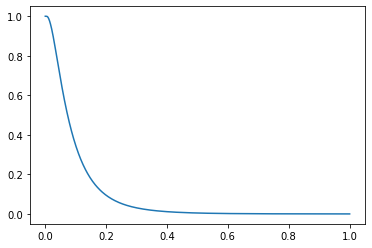

In [14]:
plt.plot(ccdf_values[0], ccdf_values[1])

In [15]:
def parse_review(text, threshold=0.0):
    print(vectorizer.get_feature_names()[143450:143550])

import pandas as pd

In [59]:
# vectorizer.get_feature_names()[i], for a given i, will output the associated word
# However, it's slow, and we don't really need it so far, so we keep to integers indices
filter_tfidf_scores = lambda r: [ (i, v) for i, v in enumerate(r) if v > 0.1 ]
filter_tfidf_scores = lambda r: r.eliminate_zeros() # [ (i, v) for i, v in enumerate(r) if v > 0.1 ]

words_per_review = []
for i, r in enumerate(res):
    if i % 10000 == 0:
        print(i)
    
    tfidf_scores = r.eliminate_zeros().toarray()[0]
    result = filter_tfidf_scores(tfidf_scores)
    words_per_review.append(len(result))

0


AttributeError: 'NoneType' object has no attribute 'toarray'

In [1]:
words_per_review[0]

NameError: name 'words_per_review' is not defined